In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances,silhouette_samples,silhouette_score
import matplotlib.pyplot as plt
import pickle

In [76]:
# reading in to_predict data
df = pd.read_csv('data/predict_preprocessed_data.csv')
df

,ID,requested_amnt,employment,extended_reason,annual_income,debt_to_income_ratio,state,revolving_balance,total_revolving_limit,loan_paid,...,reason_for_loan_wedding,employment_verified,type_of_application,home_ownership_status,delinquency_last_2yrs,fico_inquired_last_6mths,public_bankruptcies,any_tax_liens,zipcode,months_since_last_delinq
0,1000000,-0.554486,Computer Technician,Debt consolidation,-0.656154,0.065732,IN,0.098753,-0.262516,?,...,0,1,0,0,0,0,0,0,465,300.0
1,1000001,-0.737979,Teacher,Debt consolidation,-0.592514,1.167380,CA,-0.494606,-0.180333,?,...,0,1,0,0,0,0,0,0,941,300.0
2,1000002,0.752905,Portability Specialist,Other,-0.444023,-0.459544,FL,-0.474196,-0.638963,?,...,0,1,0,3,0,0,1,0,330,300.0
3,1000003,-1.082029,Internal Maintence,Credit card refinancing,-0.656154,-1.034122,AZ,-0.549936,-0.283724,?,...,0,0,0,0,0,1,0,0,864,300.0
4,1000004,-1.311396,Office administration,Other,-0.543017,-1.567466,CA,-0.710644,-0.636312,?,...,0,1,0,2,0,0,0,0,950,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345305,1345305,-1.311396,pharmacy technician,Debt consolidation,-0.741006,-1.122863,CA,-0.560718,-0.328792,?,...,0,1,0,2,0,0,0,0,952,28.0
345306,1345306,-0.279246,Senior Account Manage,Debt consolidation,-0.161181,0.092624,NY,-0.277593,-0.387114,?,...,0,1,0,2,1,2,0,0,142,19.0
345307,1345307,1.796523,NaN,Debt consolidation,0.150341,0.935218,IL,-0.371835,-0.620406,?,...,0,1,0,3,2,1,0,0,611,9.0
345308,1345308,1.441005,Quality Assurance Associate,Debt consolidation,0.339449,0.263832,CA,0.126129,-0.015969,?,...,0,0,0,0,0,0,0,0,913,300.0


In [77]:
# dropping bad cols
df = df.drop(columns=['ID', 'loan_paid', 'state', 'employment', 'extended_reason'])

In [78]:
# setting up for k-means
x = df.to_numpy()

fitted: 50
fitted: 51
fitted: 52
fitted: 53
fitted: 54


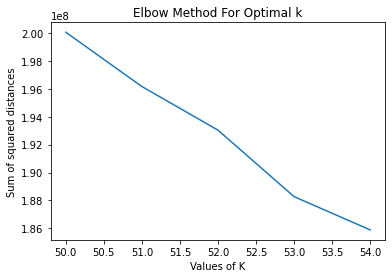

In [85]:
# performing k-means with silhouette analysis
sum_of_squared_distances = []
k_to_try = range(50, 55)
for k in k_to_try:
    kmeans = KMeans(k, random_state=42)
    y_pred = kmeans.fit(x).predict(x)
    print("fitted:", k)
    sum_of_squared_distances.append(kmeans.inertia_)
    b
plt.plot(k_to_try, sum_of_squared_distances)
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [93]:
# generating items to save
best_k = 20
kmeans = KMeans(best_k, random_state=42)
y_pred = kmeans.fit(x).predict(x)
cluster_count = best_k * [0]
for val in y_pred:
    cluster_count[val] = cluster_count[val] + 1

In [94]:
# saving using pickles
with open('data/cluster_count.pickle', 'wb') as handle:
        pickle.dump(cluster_count, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('models/k_means.pickle', 'wb') as handle:
        pickle.dump(kmeans, handle, protocol=pickle.HIGHEST_PROTOCOL)